# Whorlmaps: Visualizing Even More Contrasts

> Explanation of how to use forest_plot for contrast objects e.g delta-delta and mini-meta or regular deltas.

- order: 10

In DABEST **v2025.10.20**, we introduce a new and more compact way of visualizing bootstrap distributions:
- whorlmap

## Load libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import dabest
from dabest.multi import combine, whorlmap


Pre-compiling numba functions for DABEST...


Compiling numba functions: 100%|██████████| 11/11 [00:00<00:00, 42.85it/s]

Numba compilation complete!


## Create a simulated dataset and generate a list of corresponding dabest objects

In [ ]:
def create_delta_dataset(N=50, 
                        seed=9999, 
                        second_quarter_adjustment=3, 
                        third_quarter_adjustment= -0.5,
                        fourth_quarter_adjustment= -3, 
                        scale4=1, initial_loc = 10):
    """Create a sample dataset for delta-delta analysis."""
    np.random.seed(seed)

    # Create samples
    y = norm.rvs(loc=initial_loc, scale=0.4, size=N*4)
    y[N:2*N] = norm.rvs(loc=initial_loc + second_quarter_adjustment, scale= 1, size=N) 
    y[2*N:3*N] = norm.rvs(loc=initial_loc + third_quarter_adjustment, scale=0.4, size=N)
    y[3*N:4*N] = norm.rvs(loc=initial_loc + fourth_quarter_adjustment, scale=scale4, size=N)

    # Treatment, Rep, Genotype, and ID columns
    treatment = np.repeat(['Placebo', 'Drug'], N*2).tolist()
    genotype = np.repeat(['W', 'M', 'W', 'M'], N).tolist()
    id_col = list(range(0, N*2)) * 2

    # Combine all columns into a DataFrame
    df = pd.DataFrame({
        'ID': id_col,
        'Genotype': genotype,
        'Treatment': treatment,
        'Transcript Level': y
    })
    return df

## Working with many many Dabest objects
Let's say you have a transcriptomics experiment where you investigate the effects of administering 6 different drugs on oncogene transcripts 1 to 10. You want to find the drug that reduces all the transcripts the most effectively. In a 2x2 experiment, drug is compared to its placebo, so we will be tabulating delta-delta effect sizes. You may simulate the data as follows:

In [ ]:
dabest_objects_2d = [[None for _ in range(8)] for _ in range(6)]
labels_2d = ["Transcript 1", "Transcript 2", "Transcript 3", "Transcript 4", "Transcript 5", "Transcript 6", "Transcript 7", "Transcript 8"]
row_labels_2d = ["Drug A", "Drug B", "Drug C", "Drug D", "Drug E", "Drug F"]
drug_effect_2d = [[.9, 2, 2, .5, 1.2, 1, 3,2, 3, 4], 
             [0.1, -.3, .1, -0.3, -2, 1.2, 1,.1,-4, 2],
             [4, 4, 1, 5, 1, 3, 6.5,.5, -1.2, .4],
             [6, 2, 2, 4, 1.4, -0.5, -.5,1.1, 3, .4],
             [0.1, -.3, .1, -0.3, -2, 1.2, 1,.1,-4, 2],
             [-.3, -1, 2, 7, 1, -0.5, 4,1, 2.3, -.4],
                                ]
drug_effect_scale_2d = [[5, 10, 1, 5, 1, 2, 1,1, .1, 2], 
             [7, .2, 8, 3, 1, 4, 7,1, 5, 2],
             [15, 3, 1, 2, 1, 1, 11,1, 7, 2],
             [8, .1, 1, 5, 1, 6,1,1, 3, .4],
             [9, 10, 7, 12, 4, 2,14,10, 9, 20],
             [4, 3, 1, 4, 1, 4,4,1, 3, 4],
             ]
seeds = [1, 1000, 20, 9999, 1000, 5320]

for i in range(len(row_labels_2d)):
    for j in range(len(labels_2d)):
        df = create_delta_dataset(seed=seeds[i], 
                                  fourth_quarter_adjustment=drug_effect_2d[i][j],
                                  scale4=drug_effect_scale_2d[i][j],
                                 initial_loc = 20)
        dabest_objects_2d[i][j] = dabest.load(data=df, 
                       x=["Genotype", "Genotype"], 
                       y="Transcript Level", 
                       delta2=True, 
                       experiment="Treatment")



We are going to create a new object called MultiContrast which will contain the array of contrast objects and information about them.

In [ ]:
multi_2d_mean_diff = combine(dabest_objects_2d, labels_2d, row_labels=row_labels_2d, effect_size="mean_diff")
print("multi_2d_mean_diff is a " + str(multi_2d_mean_diff))

multi_2d_mean_diff is a MultiContrast(2D: 6x8, effect_size='mean_diff', contrast_type='delta2')


As we have seen in the previous tutorial, we can visualize these effect sizes with forest plot as follows:

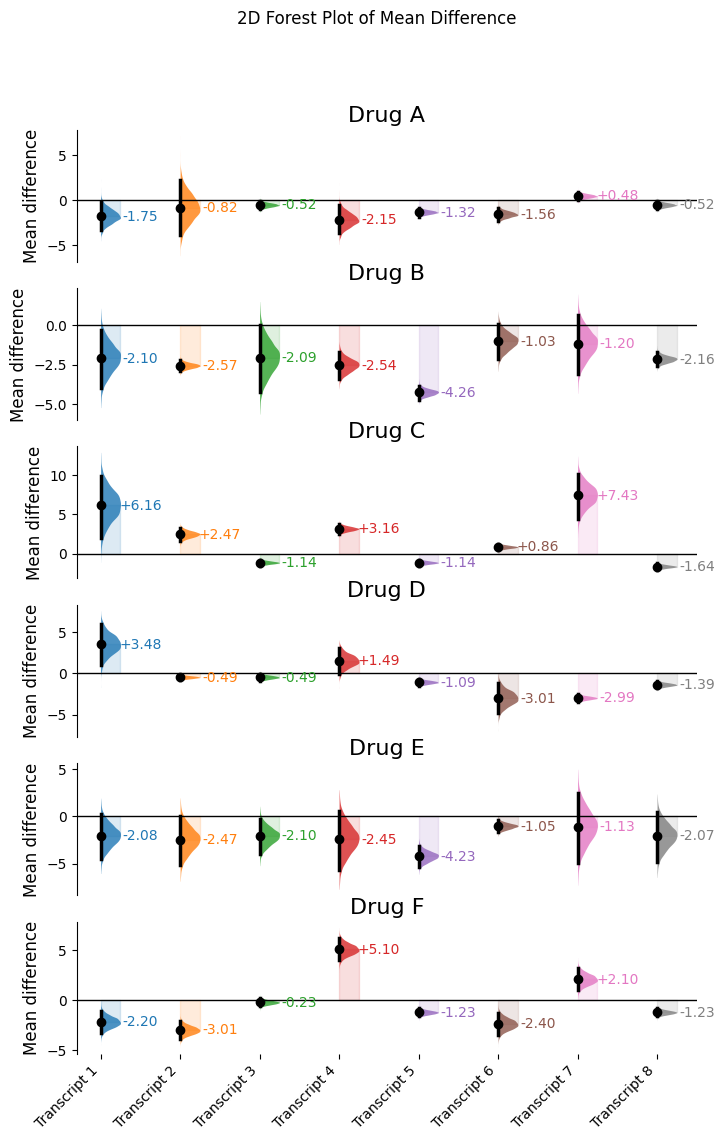

In [ ]:
multi_2d_mean_diff.forest_plot(forest_plot_title = "2D Forest Plot of Mean Difference", forest_plot_kwargs = { 'marker_size': 6});

 This data would require a stack of forest plots to visualize. So instead, we plot a whorlmap for a concise representation and use color to represent the dimension of effect size. For each effect size, the full bootstrap distribution is binned by quantiles and ranked by value, and then each bin is represented by a pixel. All the pixels correponding to the bins of effects are arranged in a spiral in a cell. The redness and the blueness of the cells represent the magnitude of the effects in the positive and negative direction.

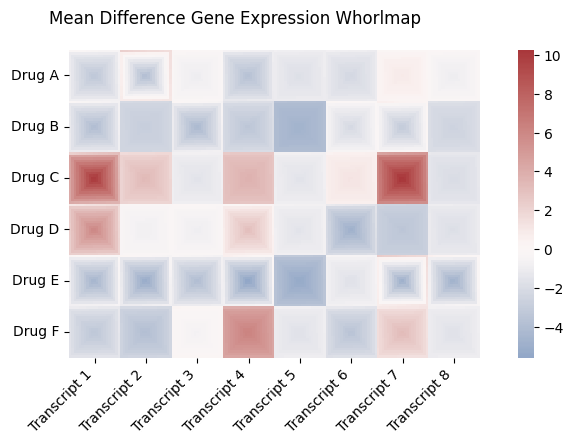

In [ ]:
multi_2d_mean_diff.whorlmap(
    title="Mean Difference Gene Expression Whorlmap",
    cmap="vlag",
    chop_tail=2.5,  # Remove 5% extreme values
    fig_size = (10, 4)
);


The resulting graphic is easy to interpret. Drug B and E induces the most broad spectrum reduction. However the data for Drug E seems a little less precise, mixing blue and red colored pixels. We can say Drug B is a surer bet. 

## Plotting whorlmaps with standardized effect sizes
We can also visualize the same array of effects in terms of standardized effect delta g. Let's plot them together in the same figure by specifying the axes to plot in:

multi_2d_delta_g is a MultiContrast(2D: 6x8, effect_size='delta_g', contrast_type='delta2')


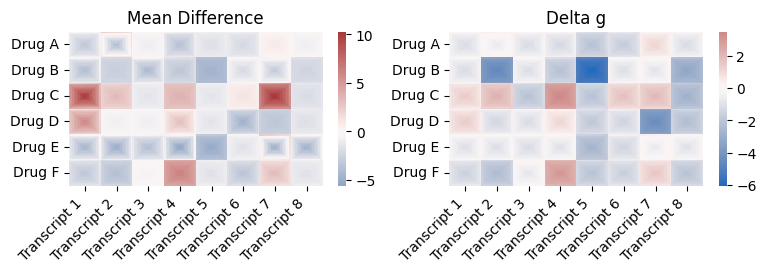

In [ ]:
figure, axes = plt.subplots(1, 2, figsize = (9, 2))
multi_2d_mean_diff.whorlmap(
    cmap="vlag",
    chop_tail=2.5,  # Remove 5% extreme values
    title="Mean Difference", ax = axes[0]
);

multi_2d_delta_g = combine(dabest_objects_2d, labels_2d, row_labels=row_labels_2d, effect_size="delta_g")
print("multi_2d_delta_g is a " + str(multi_2d_delta_g))

multi_2d_delta_g.whorlmap(
    cmap="vlag",
    chop_tail=2.5,  # Remove 5% extreme values
    title="Delta g", ax = axes[1]
);

## MultiContrast object can also handle 1-D dabest object arrays

In [ ]:
multi_1d = combine(dabest_objects_2d[0], labels_2d, row_labels="Drug A", effect_size="mean_diff")

You can plot a forest plot from this MultiContrast object

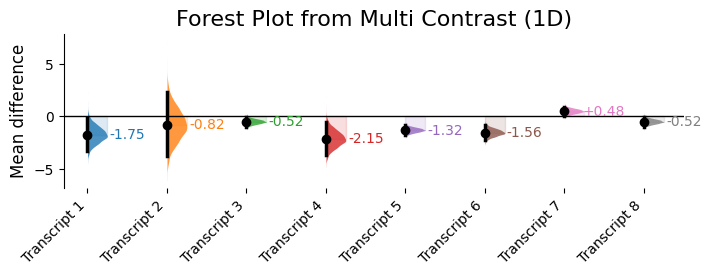

In [ ]:
fig_forest = multi_1d.forest_plot(forest_plot_kwargs = {"title":"Forest Plot from Multi Contrast (1D)", "marker_size": 6})


## 1-D whorlmap also works

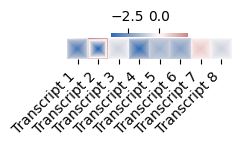

In [ ]:
multi_1d.whorlmap(
    n=21,  # Larger spiral size
    chop_tail=2.5  # Remove 5% extreme values
)
# plt.title("Customized whorlmap")
plt.show()

In [ ]:
dabest_objects_2d_2group_delta = [[None for _ in range(8)] for _ in range(6)]
for i in range(len(row_labels_2d)):
    for j in range(len(labels_2d)):
        df = create_delta_dataset(seed=seeds[i], 
                                  fourth_quarter_adjustment=drug_effect_2d[i][j],
                                  scale4=drug_effect_scale_2d[i][j],
                                 initial_loc = 20)
        dabest_objects_2d_2group_delta[i][j] = dabest.load(data=df, 
                       x="Treatment", 
                       y="Transcript Level", 
                       idx = ("Placebo", "Drug"))
multi_2d_2group_delta_mean_diff = combine(dabest_objects_2d_2group_delta, labels_2d, row_labels=row_labels_2d, effect_size="mean_diff")
print("multi_2d_mean_diff is a " + str(multi_2d_2group_delta_mean_diff))


multi_2d_mean_diff is a MultiContrast(2D: 6x8, effect_size='mean_diff', contrast_type='delta')


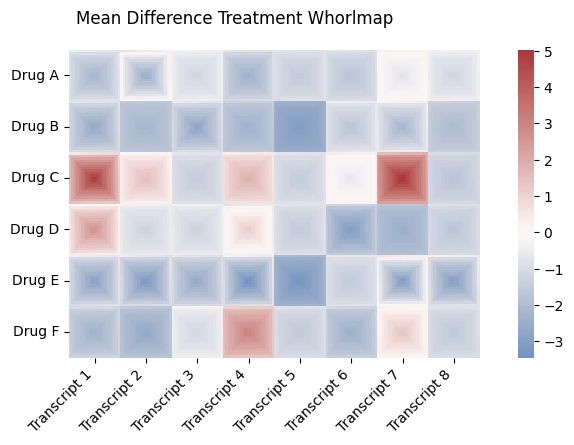

In [ ]:
multi_2d_2group_delta_mean_diff.whorlmap(
    title="Mean Difference Treatment Whorlmap",
    cmap="vlag",
    chop_tail=2.5,  # Remove 5% extreme values
    fig_size = (10, 4)
);


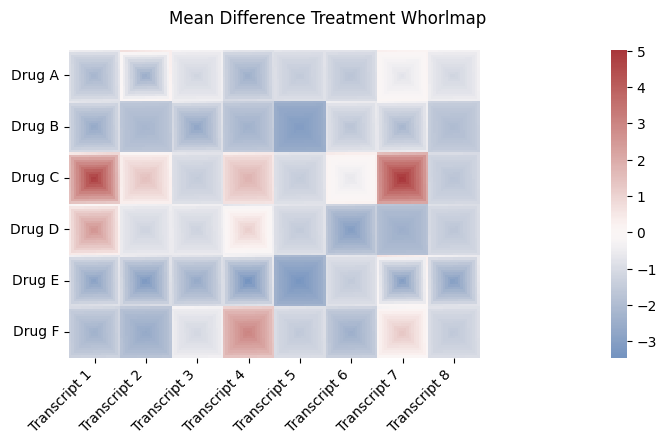

In [ ]:
multi_2d_2group_delta_mean_diff.whorlmap(
    title="Mean Difference Treatment Whorlmap",
    cmap="vlag",
    chop_tail=2.5,  # Remove 5% extreme values
    fig_size = (10, 4),
    heatmap_kwargs={'cbar_kws':{'pad':0.17}}
);


## Heatmap and plot kwargs
You can customize the whorlmap further by passing in `heatmap_kwargs` and `plot_kwargs`.

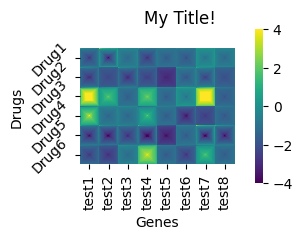

In [ ]:
multi_2d_2group_delta_mean_diff.whorlmap(
    heatmap_kwargs={'cbar_kws':{'pad':0.10}, "cmap":'viridis', "vmax":4, "vmin":-4},
    plot_kwargs={'xlabel':"Genes", 'ylabel':"Drugs", 
                 "xticklabels":['test1', 'test2', 'test3', 'test4', 'test5', 'test6', 'test7', 'test8'],
                 "xticklabels_rotation": 90, "xticklabels_ha": 'center',
                 "yticklabels": ['Drug1', 'Drug2', 'Drug3', 'Drug4', 'Drug5', 'Drug6'],
                 "yticklabels_rotation": 45, 'yticklabels_ha': "right", 'title': 'My Title!'}
);